In [1]:
from hamiltonians import transverse_field_ising_model, xyz_model
from pauli import PauliString, SiteBasis, PauliSum

import picos as pc
import numpy as np
from scipy.sparse import csr_matrix, eye, csr_array, csc_matrix
from scipy.sparse.linalg import matrix_power as sparse_power
from scipy.linalg import expm, inv, eigvalsh
from scipy.sparse.linalg import expm as sparse_expm, inv as sparse_inv
import matplotlib.pyplot as plt

%load_ext line_profiler

In [2]:
pc.patch_scipy_array_priority()

In [40]:
def thermal_solve(L, h, dlow, dhigh, ops, beta):
    H = np.real(transverse_field_ising_model(L, h).to_matrix()) / L
    basis = [np.eye(2 ** L)]
    for k in range(dlow, dhigh + 1):
        P = np.linalg.matrix_power(H, k)
        P /= np.mean(np.abs(P))
        basis.append(P)
    trM = pc.Constant("trM", [np.trace(M) for M in basis])
    trMH = pc.Constant("trMH", [np.trace(M @ H) for M in basis])
    prob = pc.Problem()
    c = pc.RealVariable('c', len(basis))
    prob.add_constraint(c.T * trM == 1)
    prob.add_constraint(pc.sum([c[i] * basis[i] for i in range(len(basis))]) >> 0)
    exp_beta_H = expm(beta * H)
    inv_beta_H = inv(exp_beta_H)
    op_mats = [PauliString(o).to_matrix() for o in ops]
    A = np.zeros((len(ops) ** 2, len(basis)))
    crow = 0
    trprod = lambda X, Y: np.einsum('ij,ji->', X, Y)
    for O1 in op_mats:
        for O2 in op_mats:
            P = O2 @ inv_beta_H @ O1 @ exp_beta_H
            Q = O1 @ O2
            for k, Hk in enumerate(basis):
                t = trprod(Hk, P - Q)
                if np.abs(np.imag(t)) > 0:
                    A[crow, k] = np.imag(t)
                else:
                    A[crow, k] = np.real(t)
            crow += 1
    prob.add_constraint(abs(np.real(A) * c) <= 1e-1)
    # print(np.max(np.abs(np.real(A))))
    prob.set_objective("min", c.T * trMH)
    tmin = prob.solve()
    prob.set_objective("max", c.T * trMH)
    tmax = prob.solve()
    return tmin.value, tmax.value

In [46]:
L, h = 5, 1
basis = SiteBasis(L, use_reflect=True, use_rot=True)
# %lprun -f thermal_solve thermal_solve(L, h, 2, 20, basis._ops, 0.1)
thermal_solve(L, h, 2, 16, basis._ops, 1)

(-0.38957854735891145, -0.38275995220490566)

In [47]:
L, h = 5, 1
basis = SiteBasis(L, use_reflect=True, use_rot=True)
betas = 1 / np.linspace(1, 4, num=20)
tmins = np.zeros_like(betas)
tmaxs = np.zeros_like(betas)
for i, beta in enumerate(betas):
    print(f'Solving {1/beta:.4f}...')
    tmins[i], tmaxs[i] = thermal_solve(L, h, 2, 16, basis._ops, beta)

Solving 1.0000...
Solving 1.1579...
Solving 1.3158...
Solving 1.4737...
Solving 1.6316...
Solving 1.7895...
Solving 1.9474...
Solving 2.1053...
Solving 2.2632...
Solving 2.4211...
Solving 2.5789...
Solving 2.7368...
Solving 2.8947...
Solving 3.0526...
Solving 3.2105...
Solving 3.3684...
Solving 3.5263...
Solving 3.6842...
Solving 3.8421...
Solving 4.0000...


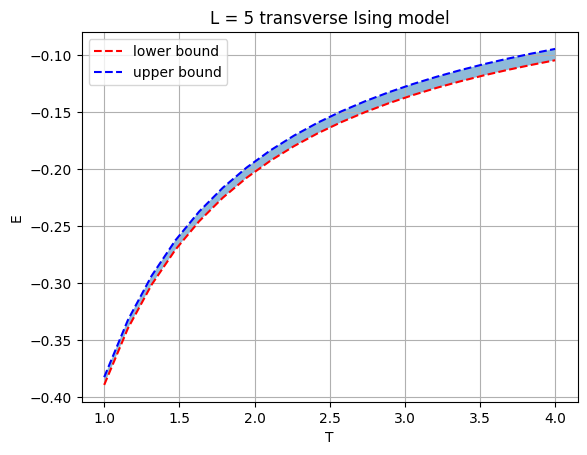

In [48]:
plt.fill_between(1/betas, tmins, tmaxs, alpha = 0.5)
plt.plot(1/betas, tmins,c ='red',linestyle='--',label='lower bound')
plt.plot(1/betas, tmaxs,c ='blue',linestyle='--',label='upper bound')
plt.xlabel('T')
plt.ylabel('E')
plt.title(f'L = {L} transverse Ising model')
plt.legend()
plt.grid()
plt.show()